# ------- (1) Dataset Selection & Imbalance Analysis -------

# Imports & Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Load Fashion-MNIST Dataset

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # scale to [-1, 1] for GANs
])

train_dataset = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

print("Training samples:", len(train_dataset))
print("Test samples:", len(test_dataset))

100%|██████████| 26.4M/26.4M [00:02<00:00, 9.67MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 154kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.85MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 15.2MB/s]

Training samples: 60000
Test samples: 10000


# Creating Class Imbalance

In [3]:
# "Sneaker" = Class 7 as minority
minority_class = 7          # Sneaker
keep_ratio = 0.10           # keep only 10%

targets = np.array(train_dataset.targets)

minority_indices = np.where(targets == minority_class)[0]
majority_indices = np.where(targets != minority_class)[0]

np.random.seed(42)
minority_kept = np.random.choice(
    minority_indices,
    size=int(len(minority_indices) * keep_ratio),
    replace=False
)

imbalanced_indices = np.concatenate([majority_indices, minority_kept])
np.random.shuffle(imbalanced_indices)

imbalanced_train_dataset = Subset(train_dataset, imbalanced_indices)

print("Original training size:", len(train_dataset))
print("Imbalanced training size:", len(imbalanced_train_dataset))

Original training size: 60000
Imbalanced training size: 54600


# Visualizing Class Imbalance

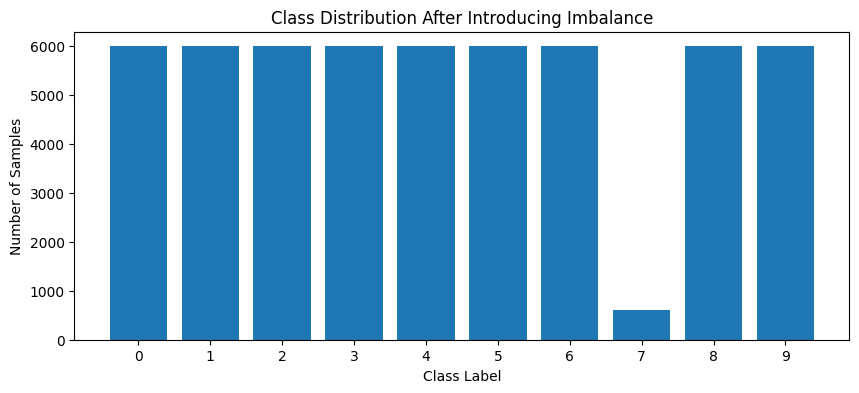

Class counts: Counter({np.int64(4): 6000, np.int64(0): 6000, np.int64(2): 6000, np.int64(8): 6000, np.int64(6): 6000, np.int64(5): 6000, np.int64(9): 6000, np.int64(3): 6000, np.int64(1): 6000, np.int64(7): 600})


In [4]:
imbalanced_targets = targets[imbalanced_indices]
class_counts = Counter(imbalanced_targets)

classes = list(range(10))
counts = [class_counts.get(c, 0) for c in classes]

plt.figure(figsize=(10,4))
plt.bar(classes, counts)
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.title("Class Distribution After Introducing Imbalance")
plt.xticks(classes)
plt.show()

print("Class counts:", class_counts)


# Visualizing Sample Images

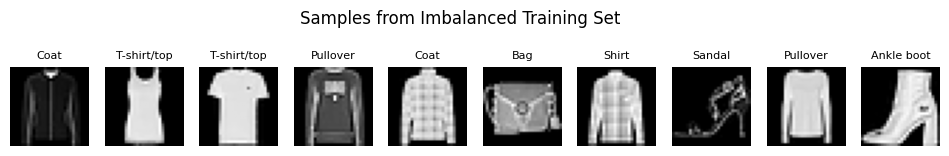

In [5]:
label_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

def show_samples(dataset, title, n=10):
    plt.figure(figsize=(12,2))
    for i in range(n):
        img, label = dataset[i]
        plt.subplot(1, n, i+1)
        plt.imshow(img.squeeze()*0.5 + 0.5, cmap="gray")
        plt.axis("off")
        plt.title(label_names[label], fontsize=8)
    plt.suptitle(title)
    plt.show()

show_samples(imbalanced_train_dataset, "Samples from Imbalanced Training Set")


# ---------------- (2) GAN Implementation ----------------

# 2.1 Vanilla GAN

# Preparing Minority-Class Data

In [6]:
from torch.utils.data import TensorDataset

# Extracting only Sneaker samples (label 7)
sneaker_images = []
for img, label in imbalanced_train_dataset:
    if label == 7:
        sneaker_images.append(img)

sneaker_images = torch.stack(sneaker_images)
print("Sneaker samples used for GAN:", sneaker_images.shape)

Sneaker samples used for GAN: torch.Size([600, 1, 28, 28])


# GAN DataLoader

In [7]:
batch_size = 128

gan_dataset = TensorDataset(sneaker_images)
gan_loader = DataLoader(
    gan_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
)

# Generator & Discriminator

In [8]:
latent_dim = 100

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z).view(-1, 1, 28, 28)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)

# Initializing Models

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G = Generator().to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=0.0002)
optimizer_D = optim.Adam(D.parameters(), lr=0.0002)


# GAN Training Loop

In [12]:
epochs = 30

for epoch in range(epochs):
    for real_imgs, in gan_loader:
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)


        # Train Discriminator

        z = torch.randn(batch_size, latent_dim).to(device)
        fake_imgs = G(z)

        real_loss = criterion(D(real_imgs), real_labels)
        fake_loss = criterion(D(fake_imgs.detach()), fake_labels)
        d_loss = real_loss + fake_loss

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()


        # Train Generator

        g_loss = criterion(D(fake_imgs), real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")


Epoch [5/30] | D Loss: 1.0349 | G Loss: 0.5348
Epoch [10/30] | D Loss: 1.5833 | G Loss: 0.5318
Epoch [15/30] | D Loss: 0.3346 | G Loss: 2.1622
Epoch [20/30] | D Loss: 0.3615 | G Loss: 2.4420
Epoch [25/30] | D Loss: 0.1964 | G Loss: 3.1650
Epoch [30/30] | D Loss: 0.2264 | G Loss: 3.1065


# Generated Sneaker Images

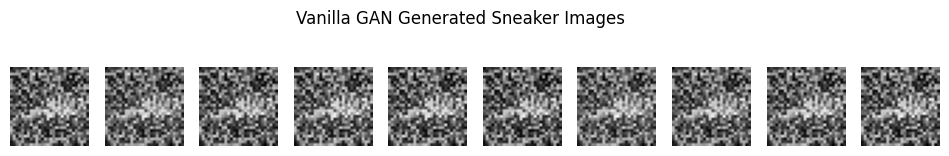

In [13]:
G.eval()
z = torch.randn(10, latent_dim).to(device)
generated_imgs = G(z).cpu().detach()

plt.figure(figsize=(12,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(generated_imgs[i].squeeze()*0.5 + 0.5, cmap="gray")
    plt.axis("off")
plt.suptitle("Vanilla GAN Generated Sneaker Images")
plt.show()


# 2.2 WGAN-GP (Wasserstein GAN with Gradient Penalty)

# Critic + Generator

In [14]:
latent_dim = 100

class WGAN_Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z).view(-1, 1, 28, 28)


class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1)  # NO sigmoid
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)


# Gradient Penalty Function

In [15]:
def gradient_penalty(critic, real, fake, device):
    batch_size = real.size(0)
    epsilon = torch.rand(batch_size, 1, 1, 1, device=device)
    interpolated = epsilon * real + (1 - epsilon) * fake
    interpolated.requires_grad_(True)

    mixed_scores = critic(interpolated)

    grad_outputs = torch.ones_like(mixed_scores, device=device)

    gradients = torch.autograd.grad(
        outputs=mixed_scores,
        inputs=interpolated,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(batch_size, -1)
    gp = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gp


# Initializing WGAN-GP

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

WG = WGAN_Generator().to(device)
C  = Critic().to(device)

lr = 1e-4
optimizer_WG = optim.Adam(WG.parameters(), lr=lr, betas=(0.0, 0.9))
optimizer_C  = optim.Adam(C.parameters(),  lr=lr, betas=(0.0, 0.9))

lambda_gp = 10
critic_steps = 5

# Training WGAN-GP

In [17]:
epochs = 40

for epoch in range(epochs):
    for real_imgs, in gan_loader:
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # =========================
        # Train Critic multiple steps
        # =========================
        for _ in range(critic_steps):
            z = torch.randn(batch_size, latent_dim, device=device)
            fake_imgs = WG(z)

            critic_real = C(real_imgs).mean()
            critic_fake = C(fake_imgs.detach()).mean()

            gp = gradient_penalty(C, real_imgs, fake_imgs.detach(), device)

            c_loss = -(critic_real - critic_fake) + lambda_gp * gp

            optimizer_C.zero_grad()
            c_loss.backward()
            optimizer_C.step()

        # =========================
        # Train Generator
        # =========================
        z = torch.randn(batch_size, latent_dim, device=device)
        fake_imgs = WG(z)
        g_loss = -C(fake_imgs).mean()

        optimizer_WG.zero_grad()
        g_loss.backward()
        optimizer_WG.step()

    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | Critic Loss: {c_loss.item():.4f} | Gen Loss: {g_loss.item():.4f}")


Epoch [5/40] | Critic Loss: -24.4747 | Gen Loss: -9.6270
Epoch [10/40] | Critic Loss: -10.3431 | Gen Loss: -17.8234
Epoch [15/40] | Critic Loss: -3.5779 | Gen Loss: -19.4618
Epoch [20/40] | Critic Loss: -1.2595 | Gen Loss: -17.9895
Epoch [25/40] | Critic Loss: -0.6012 | Gen Loss: -17.3828
Epoch [30/40] | Critic Loss: -0.6383 | Gen Loss: -15.6613
Epoch [35/40] | Critic Loss: -1.0855 | Gen Loss: -13.5062
Epoch [40/40] | Critic Loss: -2.5391 | Gen Loss: -9.0203


# Visualizing WGAN-GP Generated Samples

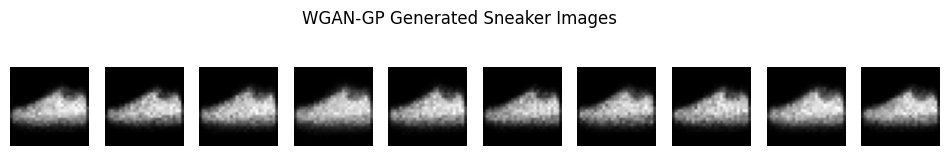

In [18]:
WG.eval()
z = torch.randn(10, latent_dim).to(device)
generated_imgs = WG(z).cpu().detach()

plt.figure(figsize=(12,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(generated_imgs[i].squeeze()*0.5 + 0.5, cmap="gray")
    plt.axis("off")
plt.suptitle("WGAN-GP Generated Sneaker Images")
plt.show()


# ---------- (3) Data Augmentation & Classification --------

# Defining The Classification Model (CNN)

# CNN Model

In [19]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)


# Baseline DataLoaders

In [20]:
batch_size = 128

train_loader_imbalanced = DataLoader(
    imbalanced_train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# Train Function

In [21]:
def train_classifier(model, train_loader, epochs=10):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        total_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}] | Loss: {total_loss/len(train_loader):.4f}")


# Evaluation Function

In [22]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score
import numpy as np

def evaluate_classifier(model, loader):
    model.eval()
    y_true, y_pred, y_prob = [], [], []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)

            y_true.extend(labels.numpy())
            y_pred.extend(outputs.argmax(1).cpu().numpy())
            y_prob.extend(probs.cpu().numpy())

    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro"
    )

    auc = roc_auc_score(
        y_true,
        np.array(y_prob),
        multi_class="ovr"
    )

    cm = confusion_matrix(y_true, y_pred)

    return acc, precision, recall, f1, auc, cm


# Train Baseline Classifier

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

baseline_model = CNNClassifier().to(device)
train_classifier(baseline_model, train_loader_imbalanced, epochs=10)

baseline_results = evaluate_classifier(baseline_model, test_loader)
baseline_results


Epoch [1/10] | Loss: 0.4920
Epoch [2/10] | Loss: 0.3172
Epoch [3/10] | Loss: 0.2705
Epoch [4/10] | Loss: 0.2425
Epoch [5/10] | Loss: 0.2167
Epoch [6/10] | Loss: 0.1932
Epoch [7/10] | Loss: 0.1741
Epoch [8/10] | Loss: 0.1594
Epoch [9/10] | Loss: 0.1436
Epoch [10/10] | Loss: 0.1281


(0.9086,
 0.9105265806732357,
 0.9086000000000001,
 0.9081558490225061,
 np.float64(0.9950598222222222),
 array([[883,   0,   8,  19,   6,   3,  78,   0,   3,   0],
        [  2, 981,   0,  13,   1,   0,   2,   0,   1,   0],
        [ 17,   1, 858,   8,  58,   0,  58,   0,   0,   0],
        [ 14,   2,   5, 928,  32,   0,  18,   0,   1,   0],
        [  1,   0,  32,  21, 900,   0,  46,   0,   0,   0],
        [  0,   0,   0,   0,   0, 989,   0,   3,   0,   8],
        [107,   1,  39,  24,  68,   0, 757,   0,   4,   0],
        [  0,   0,   0,   0,   0,  52,   0, 820,   0, 128],
        [  6,   0,   1,   6,   3,   1,   1,   1, 981,   0],
        [  0,   0,   0,   0,   0,   5,   1,   5,   0, 989]]))

# Dataset Balancing Using Vanilla GAN

# Average Class Count

In [24]:
from collections import Counter

imbalanced_labels = [label for _, label in imbalanced_train_dataset]
class_counts = Counter(imbalanced_labels)

avg_class_size = int(np.mean(list(class_counts.values())))
sneaker_current = class_counts[7]

print("Class counts:", class_counts)
print("Average class size:", avg_class_size)
print("Current Sneaker samples:", sneaker_current)
print("Synthetic Sneaker samples needed:", avg_class_size - sneaker_current)


Class counts: Counter({4: 6000, 0: 6000, 2: 6000, 8: 6000, 6: 6000, 5: 6000, 9: 6000, 3: 6000, 1: 6000, 7: 600})
Average class size: 5460
Current Sneaker samples: 600
Synthetic Sneaker samples needed: 4860


# Generating Synthetic Sneakers

In [25]:
num_to_generate = avg_class_size - sneaker_current

G.eval()
synthetic_imgs = []

with torch.no_grad():
    for _ in range((num_to_generate // batch_size) + 1):
        z = torch.randn(batch_size, latent_dim).to(device)
        fake = G(z).cpu()
        synthetic_imgs.append(fake)

synthetic_imgs = torch.cat(synthetic_imgs)[:num_to_generate]
synthetic_labels = torch.full((num_to_generate,), 7, dtype=torch.long)

print("Generated synthetic sneakers:", synthetic_imgs.shape)


Generated synthetic sneakers: torch.Size([4860, 1, 28, 28])


# Combining Real + Synthetic Data

In [26]:
# Extract real images and labels
real_imgs = []
real_labels = []

for img, label in imbalanced_train_dataset:
    real_imgs.append(img)
    real_labels.append(label)

real_imgs = torch.stack(real_imgs)
real_labels = torch.tensor(real_labels)

# Combine
balanced_imgs_vanilla = torch.cat([real_imgs, synthetic_imgs])
balanced_labels_vanilla = torch.cat([real_labels, synthetic_labels])

vanilla_balanced_dataset = TensorDataset(
    balanced_imgs_vanilla,
    balanced_labels_vanilla
)

print("Balanced dataset size (Vanilla GAN):", len(vanilla_balanced_dataset))


Balanced dataset size (Vanilla GAN): 59460


# Balanced DataLoader

In [27]:
train_loader_vanilla = DataLoader(
    vanilla_balanced_dataset,
    batch_size=batch_size,
    shuffle=True
)


# Train Classifier

In [28]:
vanilla_model = CNNClassifier().to(device)
train_classifier(vanilla_model, train_loader_vanilla, epochs=10)

vanilla_results = evaluate_classifier(vanilla_model, test_loader)
vanilla_results


Epoch [1/10] | Loss: 0.4560
Epoch [2/10] | Loss: 0.2936
Epoch [3/10] | Loss: 0.2514
Epoch [4/10] | Loss: 0.2218
Epoch [5/10] | Loss: 0.1973
Epoch [6/10] | Loss: 0.1783
Epoch [7/10] | Loss: 0.1587
Epoch [8/10] | Loss: 0.1438
Epoch [9/10] | Loss: 0.1306
Epoch [10/10] | Loss: 0.1135


(0.9063,
 0.9084609195650156,
 0.9062999999999999,
 0.9056667389093167,
 np.float64(0.9951519555555557),
 array([[877,   0,  12,  19,   4,   1,  77,   0,  10,   0],
        [  3, 979,   0,  13,   0,   0,   3,   0,   2,   0],
        [ 15,   1, 899,  10,  28,   0,  45,   0,   2,   0],
        [ 10,   2,  12, 935,  15,   0,  24,   0,   2,   0],
        [  2,   0,  70,  26, 843,   0,  56,   0,   3,   0],
        [  0,   0,   0,   0,   0, 987,   0,   5,   0,   8],
        [ 99,   1,  51,  20,  52,   0, 771,   0,   6,   0],
        [  0,   0,   0,   0,   0,  46,   0, 796,   1, 157],
        [  5,   1,   1,   4,   0,   3,   1,   1, 984,   0],
        [  0,   0,   0,   0,   0,   3,   1,   4,   0, 992]]))

# Dataset Balancing Using WGAN-GP

# Generating Synthetic Sneakers

In [29]:
num_to_generate = avg_class_size - sneaker_current

WG.eval()
synthetic_imgs_wgan = []

with torch.no_grad():
    for _ in range((num_to_generate // batch_size) + 1):
        z = torch.randn(batch_size, latent_dim).to(device)
        fake = WG(z).cpu()
        synthetic_imgs_wgan.append(fake)

synthetic_imgs_wgan = torch.cat(synthetic_imgs_wgan)[:num_to_generate]
synthetic_labels_wgan = torch.full((num_to_generate,), 7, dtype=torch.long)

print("Generated synthetic sneakers (WGAN-GP):", synthetic_imgs_wgan.shape)


Generated synthetic sneakers (WGAN-GP): torch.Size([4860, 1, 28, 28])


# Combining Real + WGAN-GP Synthetic Data

In [30]:
balanced_imgs_wgan = torch.cat([real_imgs, synthetic_imgs_wgan])
balanced_labels_wgan = torch.cat([real_labels, synthetic_labels_wgan])

wgan_balanced_dataset = TensorDataset(
    balanced_imgs_wgan,
    balanced_labels_wgan
)

print("Balanced dataset size (WGAN-GP):", len(wgan_balanced_dataset))


Balanced dataset size (WGAN-GP): 59460


# Balanced DataLoader

In [31]:
train_loader_wgan = DataLoader(
    wgan_balanced_dataset,
    batch_size=batch_size,
    shuffle=True
)


# Train & Evaluate

In [32]:
wgan_model = CNNClassifier().to(device)
train_classifier(wgan_model, train_loader_wgan, epochs=10)

wgan_results = evaluate_classifier(wgan_model, test_loader)
wgan_results


Epoch [1/10] | Loss: 0.4642
Epoch [2/10] | Loss: 0.2957
Epoch [3/10] | Loss: 0.2512
Epoch [4/10] | Loss: 0.2211
Epoch [5/10] | Loss: 0.1968
Epoch [6/10] | Loss: 0.1772
Epoch [7/10] | Loss: 0.1606
Epoch [8/10] | Loss: 0.1439
Epoch [9/10] | Loss: 0.1270
Epoch [10/10] | Loss: 0.1138


(0.9077,
 0.9093527973547417,
 0.9077,
 0.9061661800617914,
 np.float64(0.9948147722222223),
 array([[898,   0,  10,  42,   2,   1,  39,   0,   8,   0],
        [  3, 985,   1,   9,   1,   0,   1,   0,   0,   0],
        [ 26,   1, 896,  18,  26,   0,  30,   0,   3,   0],
        [  6,   3,   6, 968,  10,   0,   7,   0,   0,   0],
        [  0,   0,  63,  46, 846,   0,  43,   0,   2,   0],
        [  0,   0,   0,   0,   0, 987,   0,   4,   1,   8],
        [137,   1,  69,  58,  49,   0, 678,   0,   8,   0],
        [  0,   0,   0,   0,   0,  36,   0, 853,   0, 111],
        [  6,   1,   2,   7,   2,   1,   2,   0, 979,   0],
        [  0,   0,   0,   0,   0,   4,   1,   8,   0, 987]]))

# ------------------------- (4) Evaluation --------------------------

# Results Table

In [33]:
import pandas as pd

results_df = pd.DataFrame({
    "Scenario": [
        "Imbalanced Dataset",
        "Balanced with Vanilla GAN",
        "Balanced with WGAN-GP"
    ],
    "Accuracy": [
        baseline_results[0],
        vanilla_results[0],
        wgan_results[0]
    ],
    "Precision (Macro)": [
        baseline_results[1],
        vanilla_results[1],
        wgan_results[1]
    ],
    "Recall (Macro)": [
        baseline_results[2],
        vanilla_results[2],
        wgan_results[2]
    ],
    "F1-Score (Macro)": [
        baseline_results[3],
        vanilla_results[3],
        wgan_results[3]
    ],
    "AUC-ROC": [
        baseline_results[4],
        vanilla_results[4],
        wgan_results[4]
    ]
})

results_df


,Scenario,Accuracy,Precision (Macro),Recall (Macro),F1-Score (Macro),AUC-ROC
0,Imbalanced Dataset,0.9086,0.910527,0.9086,0.908156,0.995060
1,Balanced with Vanilla GAN,0.9063,0.908461,0.9063,0.905667,0.995152
2,Balanced with WGAN-GP,0.9077,0.909353,0.9077,0.906166,0.994815


# Metric Comparison Plot

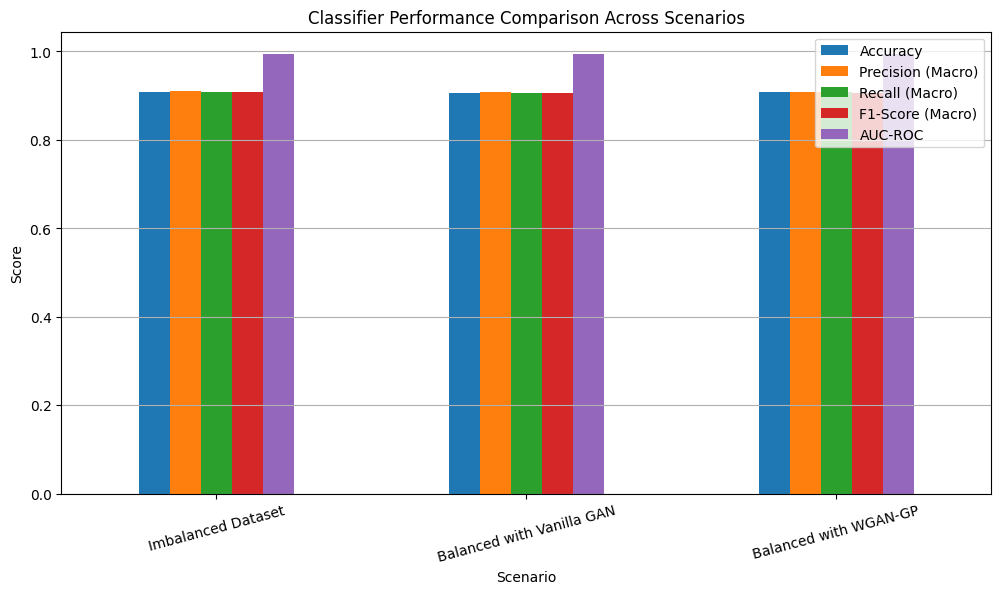

In [34]:
results_df.set_index("Scenario").plot(
    kind="bar",
    figsize=(12,6)
)
plt.title("Classifier Performance Comparison Across Scenarios")
plt.ylabel("Score")
plt.xticks(rotation=15)
plt.grid(axis="y")
plt.show()


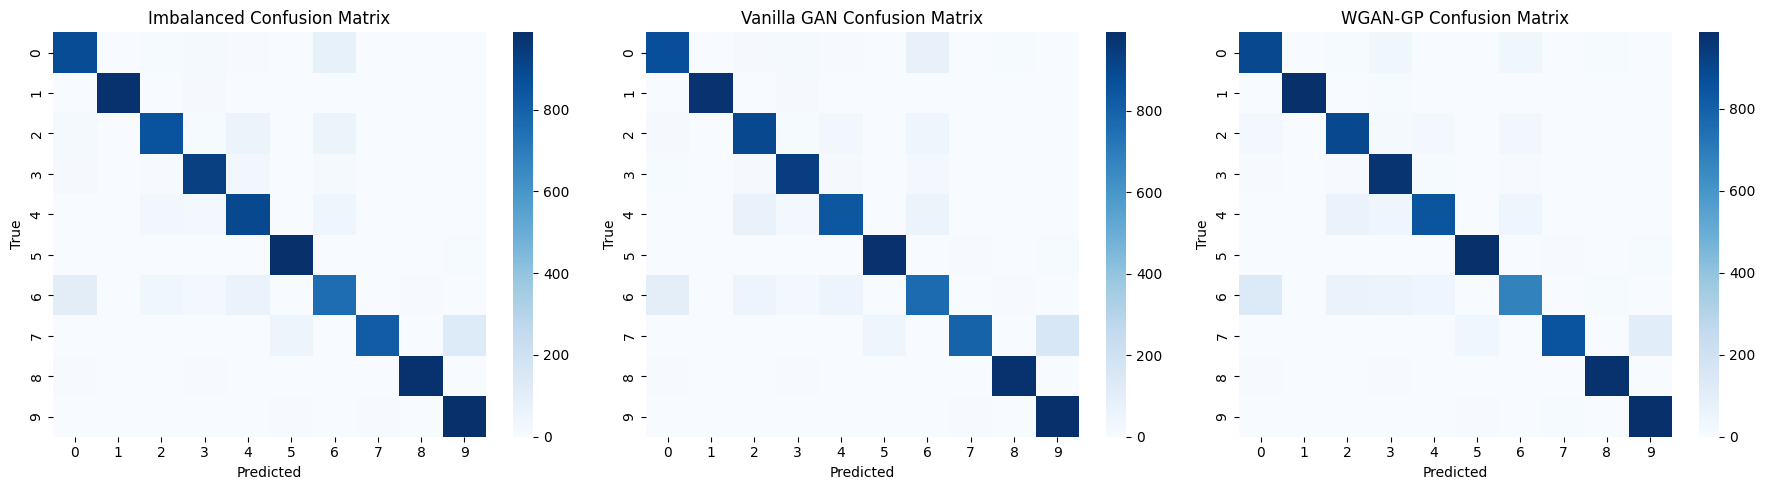

In [35]:
import seaborn as sns

scenarios = {
    "Imbalanced": baseline_results[5],
    "Vanilla GAN": vanilla_results[5],
    "WGAN-GP": wgan_results[5]
}

plt.figure(figsize=(18,5))
for i, (name, cm) in enumerate(scenarios.items()):
    plt.subplot(1,3,i+1)
    sns.heatmap(cm, annot=False, cmap="Blues", fmt="d")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")

plt.tight_layout()
plt.show()
